## Sequencing and Synthesis Errors in the TYK2 DMS Library


0. [Executive Summary](#part0)
1. [Global Error Rate Estimates](#part1)
2. [Distinguishing Synthesis from Sequencing Errors](#part2)
3. [Error Distributions by Position](#part3)
4. [Error Distributions by Base Identity](#part4)

### Executive Summary <a name="part0"></a>

- This analysis of sequencing error rates uses barcode mapping data from TYK2 Chunks 3-6, sequencing run `VH00964_8_AAAVVT7HV`
- The median proportion of reads which exactly match an expected oligo is 66.5% across barcode mapping samples
    - Thus, the median combined error rate (including synthesis, PCR, and sequencing) is 33.5%
- Substitutions are highly correlated across all samples in the same chunk, while indels are much more correlate within rather than across A/B group
- Errors (including substitutions and indels) are uniformly along the length of the oligo
- Most substitutions are likely sequencing errors (very low base calling quality score)
  - For example, if calling genetic variants in a human, base qualities this low would not be used
  - However, the most common substitution in _both_ high and low quality bases is G>T
  - In high quality basecalls only, the second most abundant substitution is C>T

### Global Error Rate Estimates <a name="part1"></a>

For the main DMS experiment, we want to use only error-free, valid oligo-barcode associations from these data and we apply a series of filters to define what "valid" means. However, it is also useful to characterize the actual content of the removed barcode mapping data. Each barcode mapping sample generates a set of paired-end sequences, which are classified into the bins shown below. These bins are _non-overlapping_ such that `total fragments` equals the sum of all other fields for a given sample:

In [78]:
library(jsonlite)
library(knitr)
library(scico)
library(fs)
library(ggpubr)
library(data.table)
library(tidyverse)

In [91]:
options(warn = -1)
qcdata <- fromJSON("../pipeline/batch2/multiqc_data/multiqc_data.json",
                   flatten = TRUE)[["report_general_stats_data"]] %>%
    mutate_all(as.numeric) %>%
    mutate(source = c("align","trim","merge")) %>%
    pivot_longer(names_to = "field", values_to = "value", -source) %>%
    filter(!is.na(value)) %>%
    separate(field, c("sample","field"), sep = "\\.", extra = "merge") %>%
    mutate(sample = gsub("_R1","",sample),
           value = as.numeric(value)) %>%
    select(-source) %>%
    pivot_wider(names_from = field, values_from = value) %>%
    mutate(combopairs = inniepairs + outiepairs,
           imperfect = c(12885545,13042989,10894684,9638255,
                         12638482,12855552,12800230,11344057,
                         12322100,12155314,11830789,10015693,
                         10093106,9931246,6165102,11464951),
           unique_perfect = uniquely_mapped - imperfect,
           unmapped_all = unmapped_other + unmapped_tooshort)

qcdata_percent <- qcdata %>%
    pivot_longer(names_to = "field", values_to = "value", c(-sample, -totalpairs)) %>%
    mutate(value = value*100 / totalpairs,
           totalpairs = 100) %>%
    pivot_wider(names_from = field, values_from = value)

In [95]:
qcdata %>%
    select(sample,
           "total fragments" = totalpairs,
           "uncombined" = uncombopairs,
           "empty" = barcodeExtract.r_too_short,
           "no assignment" = unmapped_all,
           "ambiguous assignment" = multimapped_toomany,
           "unique assignment with errors" = imperfect,
           "unique assignment with no errors" = unique_perfect) %>%
    arrange(sample) %>%
    kable(digits = 3) 



|sample | total fragments| uncombined| empty| no assignment| ambiguous assignment| unique assignment with errors| unique assignment with no errors|
|:------|---------------:|----------:|-----:|-------------:|--------------------:|-----------------------------:|--------------------------------:|
|3A_1   |        56995569|    1467442|     0|       1088960|              3550136|                      11830789|                         39058242|
|3A_2   |        57329625|    1503360|     2|       1215396|              3629955|                      10894684|                         40086228|
|3B_1   |        48504137|    1266729|     1|        931425|              2998564|                       6165102|                         37142316|
|3B_2   |        41862423|    1109183|     0|        895508|              2692060|                      12800230|                         24365442|
|4A_1   |        56866293|    1462627|     2|       1049978|              3019290|                      114649

And the same table as a rounded percentage:

In [96]:
qcdata_percent %>%
    select(sample,
           "total fragments" = totalpairs,
           "uncombined" = uncombopairs,
           "empty" = barcodeExtract.r_too_short,
           "no assignment" = unmapped_all,
           "ambiguous assignment" = multimapped_toomany,
           "unique assignment with errors" = imperfect,
           "unique assignment with no errors" = unique_perfect) %>%
    mutate_if(is.numeric, funs(as.character(signif(., 4)))) %>%
    arrange(sample) %>%
    kable(digits = 3) 



|sample |total fragments |uncombined |empty     |no assignment |ambiguous assignment |unique assignment with errors |unique assignment with no errors |
|:------|:---------------|:----------|:---------|:-------------|:--------------------|:-----------------------------|:--------------------------------|
|3A_1   |100             |2.575      |0         |1.911         |6.229                |20.76                         |68.53                            |
|3A_2   |100             |2.622      |3.489e-06 |2.12          |6.332                |19                            |69.92                            |
|3B_1   |100             |2.612      |2.062e-06 |1.92          |6.182                |12.71                         |76.58                            |
|3B_2   |100             |2.65       |0         |2.139         |6.431                |30.58                         |58.2                             |
|4A_1   |100             |2.572      |3.517e-06 |1.846         |5.309                |

Under this framework, the fragments that are `uncombined`, `empty`, or have `no assignment` are the remaining dark matter of the dataset - they would require further processing to characterize. This is definitely possible - some manual exploration suggests that virtually all reads (>99%) can be aligned to TYK2, but simply cannot be meaningfully resolved into our expected oligos.

The remaining reads can be uniquely identified as originating from a particular oligo, and are either imperfect or exact matches. The median exact match frequncy is 66.5%, meaning that approx. 2/3 of the raw read count from a given paired end data set are exact copies of an expected oligo sequence.

### Distinguishing Synthesis from Sequencing Errors <a name="part2"></a>

While useful, the above does not distinguish between squencing and synthesis errors. Fortunately, we have replicates which should differ in their sequencing, but not synthesis, errors although the difference is probabilistic rather than absolute. One measure of similarity is the Jaccard index, which quantifies the overlap between two groups of errors. It is defined as the intersection of the errors detected in two samples divided by the union of those errors - a value of 1 means that all detected errors are shared, while a value of zero means that no detected variants are shared. A "detected" variant means at least one read - we aren't yet considering depth. We can show this index as a heatmap, separated by indels and substitutions:

In [ ]:
files_indel <- dir_ls("../pipeline/batch2/",glob = "*indels-counts*")
indels <- files_indel %>% 
    map_dfr(fread, col.names = c("count", "type","length","pos","oligo"), sep = "\t", .id = "sample") %>%
    mutate(sample = gsub("../pipeline/batch2/|.dnaerrors-indels-counts.tsv","",sample,perl=T))
samples <- combn(unique(indels$sample),2)
jaccardindices <- tibble("sample1" = character(),
                         "sample2" = character(),
                         "jaccard_index" = numeric())

for(i in 1:ncol(samples)){

    message(paste0(samples[1,i]," ",samples[2,i]))
    flush.console()
    
    d1 <- indels %>% 
        filter(sample == samples[1,i]) %>%
        mutate(id = paste0(type,"_",length,"_",pos,"_",oligo,"_")) %>%
        select(id) %>% unlist()

    d2 <- indels %>% 
        filter(sample == samples[2,i]) %>%
        mutate(id = paste0(type,"_",length,"_",pos,"_",oligo,"_")) %>%
        select(id) %>% unlist()

    jacc <- length(intersect(d1,d2)) / length(union(d1,d2))
    toAdd <- tibble("sample1" = samples[1,i], "sample2" = samples[2,i], "jaccard_index" = jacc)
    jaccardindices <- bind_rows(jaccardindices, toAdd)

}

write_tsv(jaccardindices, "../pipeline/batch2/jaccard-indels.tsv", col_names = F)

In [ ]:
files_substitutions <- dir_ls("../pipeline/batch2/",glob = "*substitutions-counts*")

substitutions <- files_substitutions %>% 
    map_dfr(fread, col.names = c("count","pos","ref","alt","oligo"), sep = "\t", .id = "sample") %>%
    mutate(sample = gsub("../pipeline/batch2/|.dnaerrors-substitutions-counts.tsv","",sample,perl=T))

samples <- combn(unique(substitutions$sample),2)

jaccardindices_substitutions <- tibble("sample1" = character(),
                                     "sample2" = character(),
                                     "jaccard_index" = numeric())

for(i in 1:ncol(samples)){

    message(paste0(samples[1,i]," ",samples[2,i]))
    flush.console()
    
    d1 <- substitutions %>% 
        filter(sample == samples[1,i]) %>%
        mutate(id = paste0(pos,"_",ref,"_",alt,"_",oligo,"_")) %>%
        select(id) %>% unlist()

    d2 <- substitutions %>% 
        filter(sample == samples[2,i]) %>%
        mutate(id = paste0(pos,"_",ref,"_",alt,"_",oligo,"_")) %>%
        select(id) %>% unlist()

    jacc <- length(intersect(d1,d2)) / length(union(d1,d2))
    toAdd <- tibble("sample1" = samples[1,i], "sample2" = samples[2,i], "jaccard_index" = jacc)
    jaccardindices_substitutions <- bind_rows(jaccardindices_substitutions, toAdd)

}

write_tsv(jaccardindices_substitutions, "../pipeline/batch2/jaccard-substitutions.tsv", col_names = F)

In [ ]:
jaccardindices <- read_tsv("../pipeline/batch2/jaccard-indels.tsv", col_names = c("sample1","sample2","jaccard_index"))
jaccardindices_substitutions <- read_tsv("../pipeline/batch2/jaccard-substitutions.tsv", col_names = c("sample1","sample2","jaccard_index"))

files_indel <- dir_ls("../pipeline/batch2/",glob = "*indels-counts.tsv")
indels <- files_indel %>% 
    map_dfr(fread, col.names = c("count", "type","length","pos","oligo"), sep = "\t", .id = "sample") %>%
    mutate(sample = gsub("../pipeline/batch2/|.dnaerrors-indels-counts.tsv","",sample,perl=T))

files_substitutions <- dir_ls("../pipeline/batch2/",glob = "*substitutions-counts.tsv")
substitutions <- files_substitutions %>% 
    map_dfr(fread, col.names = c("count","pos","ref","alt","oligo"), sep = "\t", .id = "sample") %>%
    mutate(sample = gsub("../pipeline/batch2/|.dnaerrors-substitutions-counts.tsv","",sample,perl=T))

samples <- combn(unique(indels$sample),2)

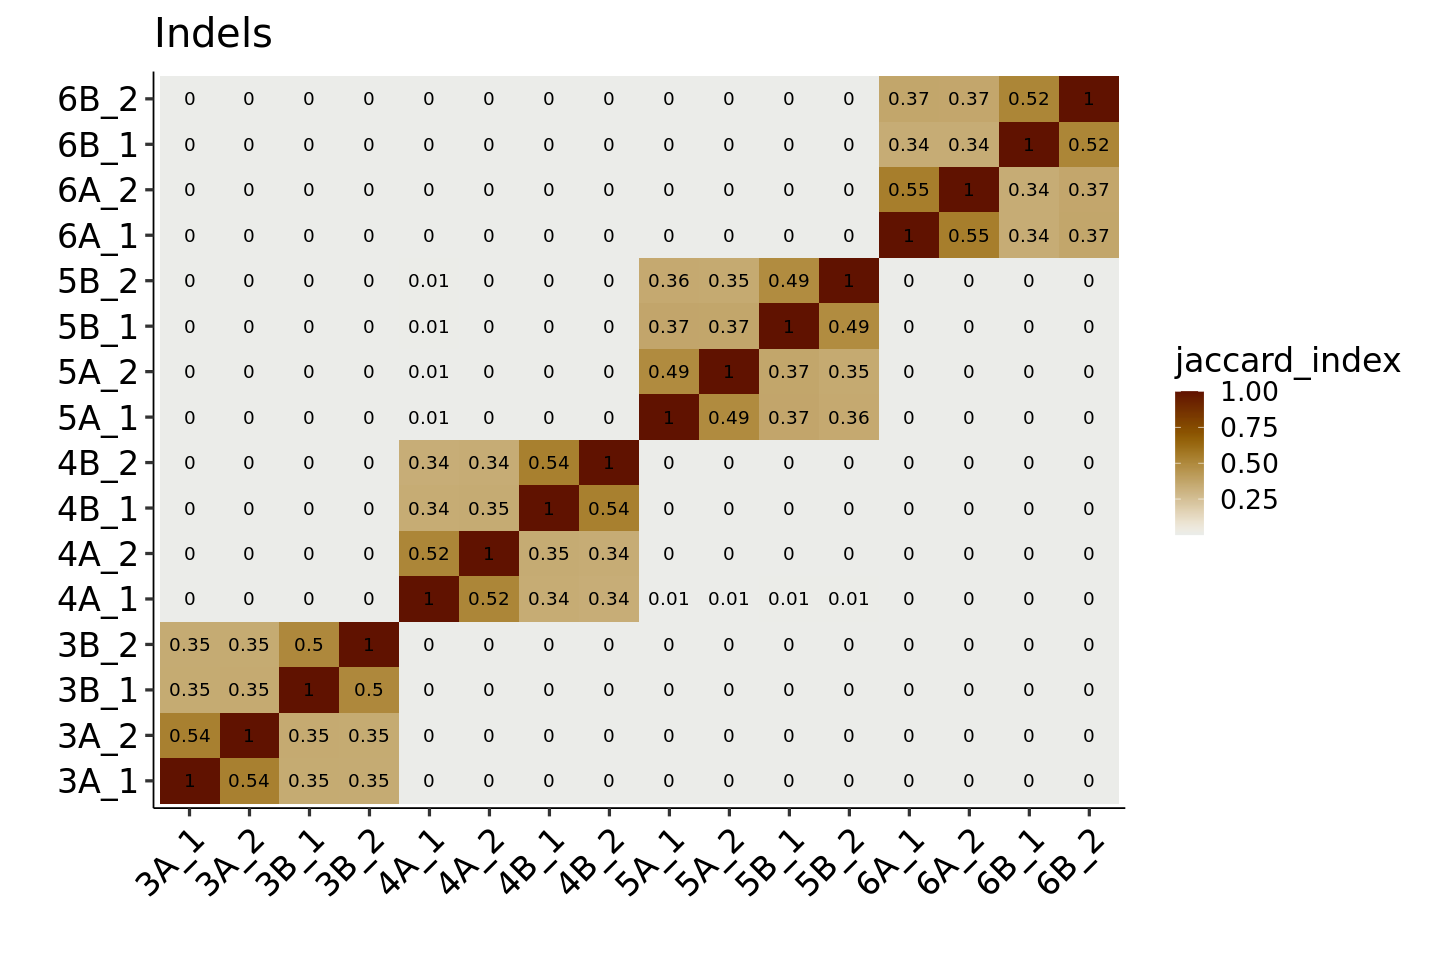

In [182]:
options(repr.plot.width = 12, repr.plot.height = 8)

extra <- bind_rows(tibble("sample1" = unique(c(samples)), "sample2" = unique(c(samples)), "jaccard_index" = 1),
                   tibble("sample1" = jaccardindices$sample2, "sample2" = jaccardindices$sample1, "jaccard_index" = jaccardindices$jaccard_index))

ggplot(bind_rows(jaccardindices, extra)) +
    geom_tile(aes(x = sample2, y = sample1, fill = jaccard_index)) +
    geom_text(aes(x = sample2, y = sample1, label = round(jaccard_index,2))) +
    theme_pubr(base_size = 20, x.text.angle = 45) +
    theme(legend.pos= "right") +
    scale_fill_scico(palette = "vik", midpoint = 0) +
    xlab("") + ylab("") + 
    ggtitle("Indels")

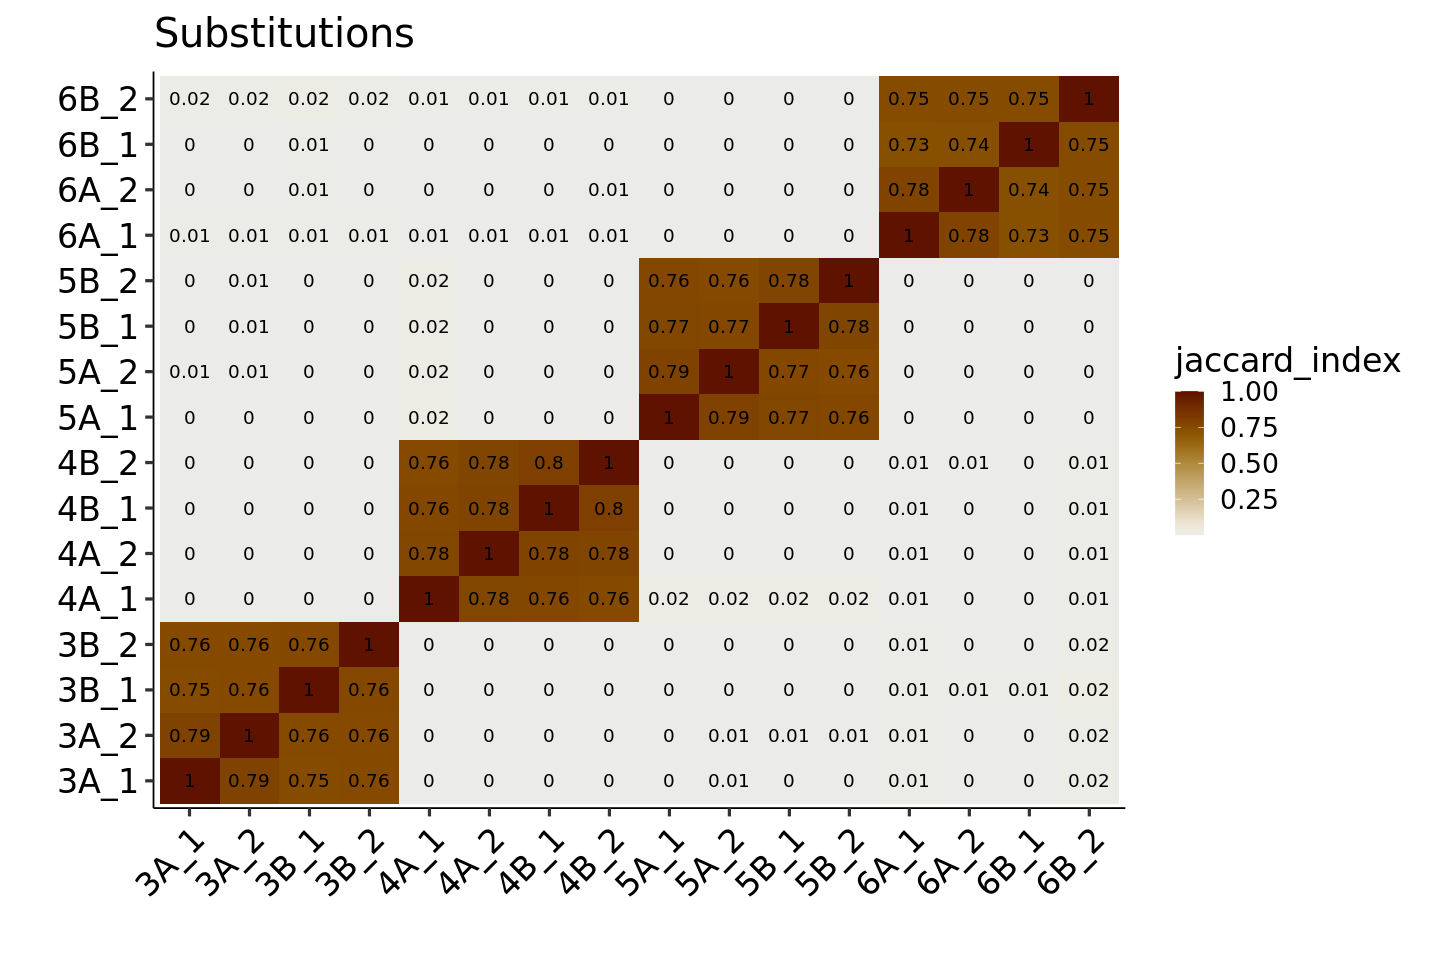

In [102]:
options(repr.plot.width = 12, repr.plot.height = 8)

extra <- bind_rows(tibble("sample1" = unique(c(samples)), "sample2" = unique(c(samples)), "jaccard_index" = 1),
                   tibble("sample1" = jaccardindices_substitutions$sample2, "sample2" = jaccardindices_substitutions$sample1, "jaccard_index" = jaccardindices_substitutions$jaccard_index))

ggplot(bind_rows(jaccardindices_substitutions, extra)) +
    geom_tile(aes(x = sample2, y = sample1, fill = jaccard_index)) +
    geom_text(aes(x = sample2, y = sample1, label = round(jaccard_index,2))) +
    theme_pubr(base_size = 20, x.text.angle = 45) +
    theme(legend.pos= "right") +
    scale_fill_scico(palette = "vik", midpoint = 0) +
    xlab("") + ylab("") + 
    ggtitle("Substitutions")

Samples within the same chunk share 75-80% of substitution errors regardless of whether they are group A or B. In contrast, indel error sharing is much higher within A/B group in each chunk (50-55% vs ~35%).

Another informative view that incorporates the abundance of each error is the Pearson correlation of the log counts across errors in each sample. For replicate pairs, the observed errors (both indels and substitutions) are very well correlated:

In [183]:
indels_wide <- indels %>% pivot_wider(names_from = sample, values_from = count, values_fill = 0)
indels_cor <- cor(log(indels_wide[,5:20]+1)) %>% as_tibble() %>% mutate(sample = names(indels_wide)[5:20]) %>% melt()

Using sample as id variables



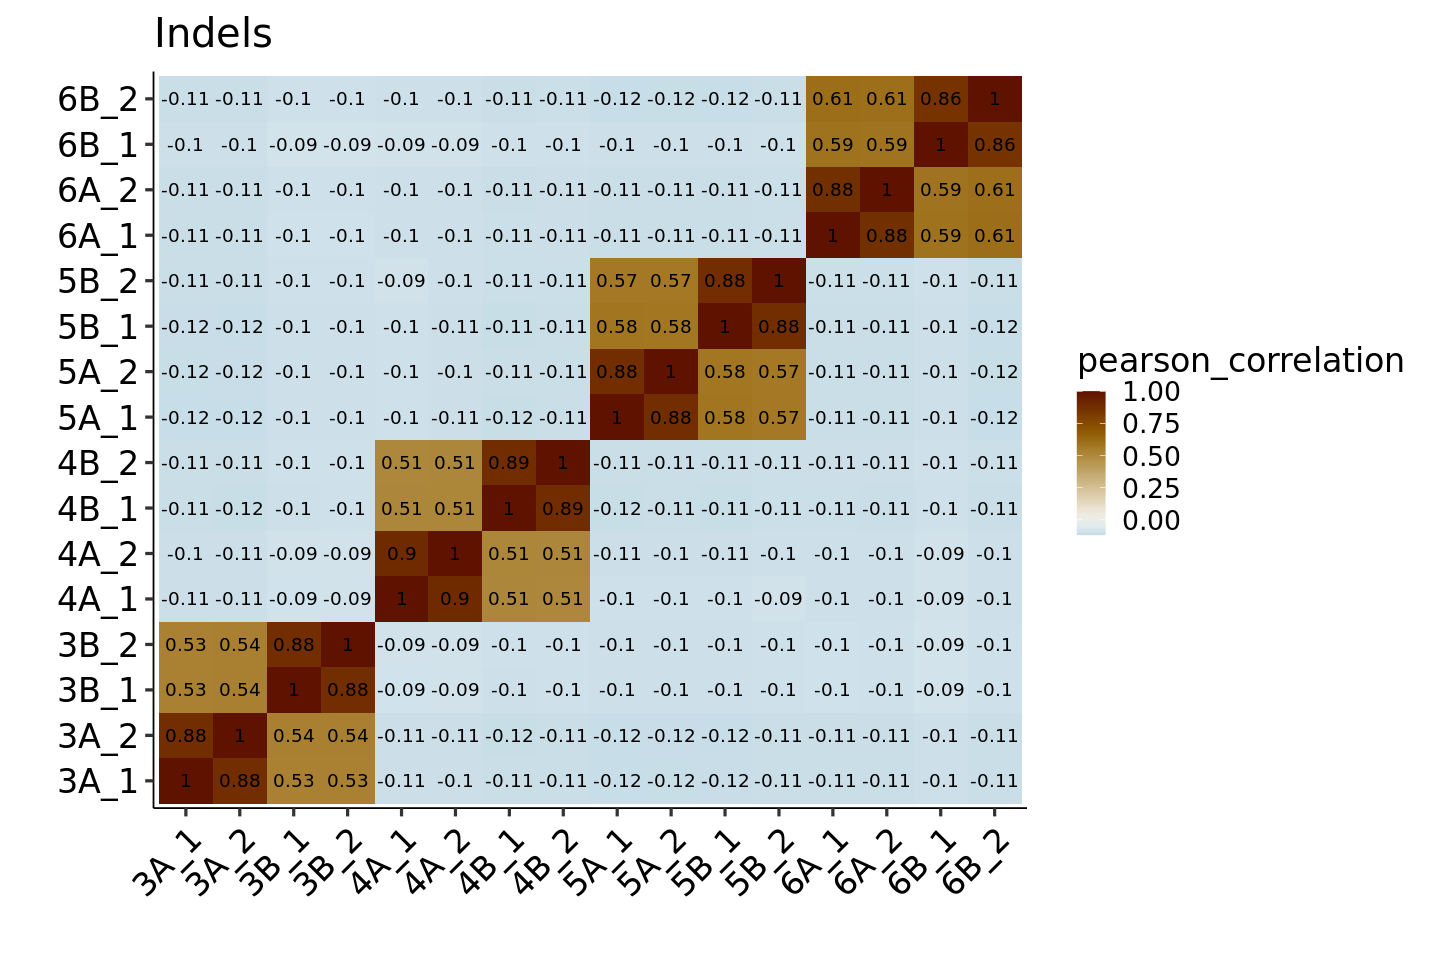

In [184]:
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(indels_cor %>% rename("pearson_correlation" = value)) +
    geom_tile(aes(x = sample, y = variable, fill = pearson_correlation)) +
    geom_text(aes(x = sample, y = variable, label = round(pearson_correlation,2))) +
    theme_pubr(base_size = 20, x.text.angle = 45) +
    theme(legend.pos= "right") +
    scale_fill_scico(palette = "vik", midpoint = 0) +
    xlab("") + ylab("") + 
    ggtitle("Indels")

In [ ]:
subs_wide <- substitutions %>% pivot_wider(names_from = sample, values_from = count, values_fill = 0)
subs_cor <- cor(log(subs_wide[,5:20]+1)) %>% as_tibble() %>% mutate(sample = names(subs_wide)[5:20]) %>% melt()

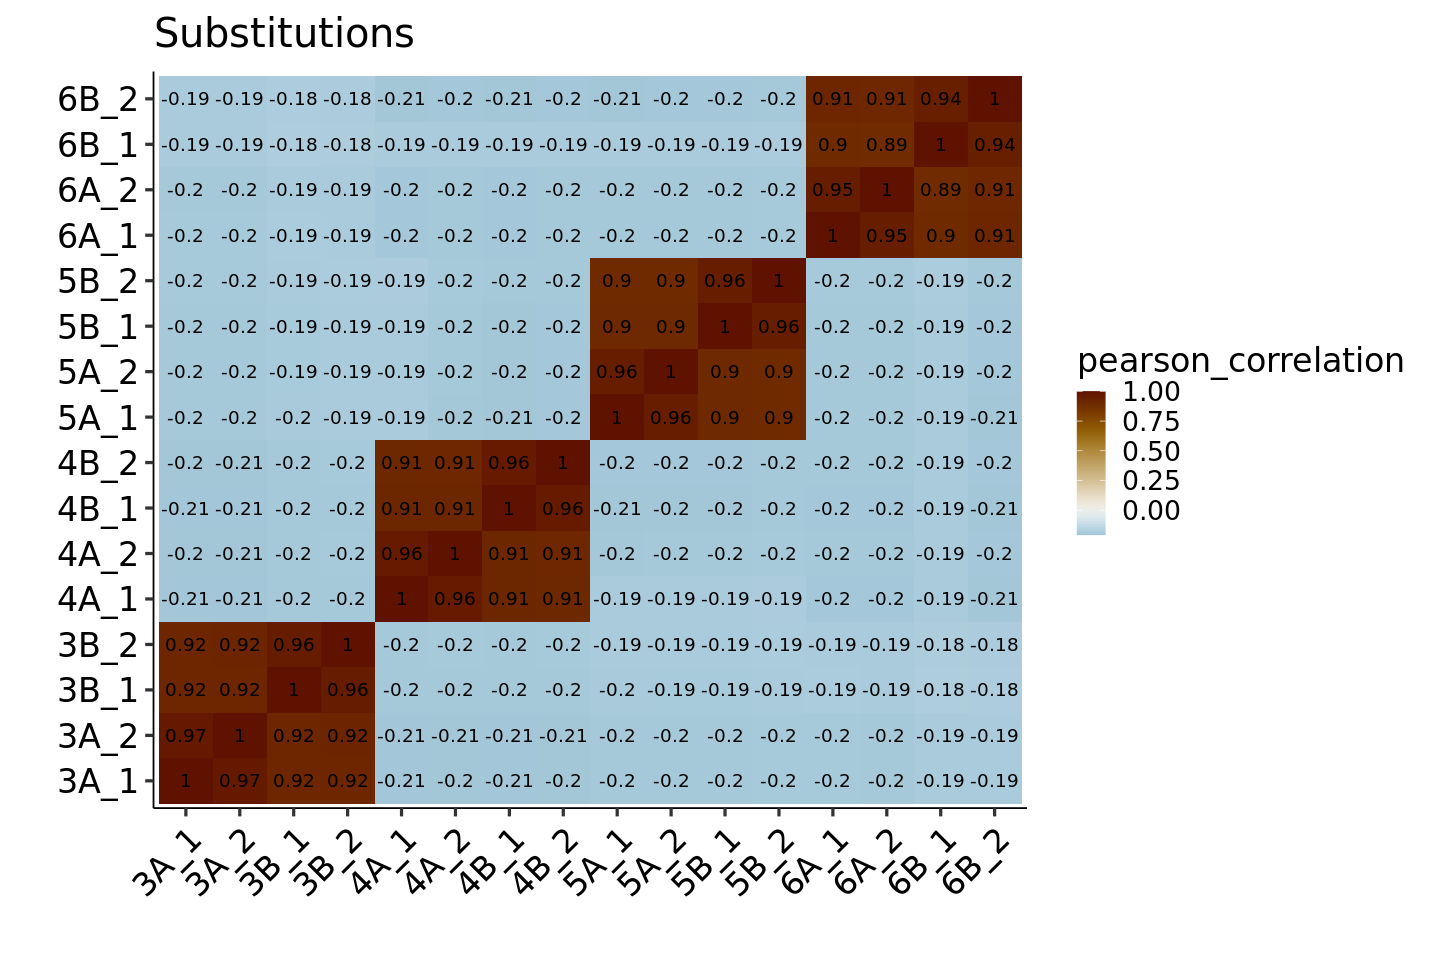

In [109]:
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(subs_cor %>% rename("pearson_correlation" = value)) +
    geom_tile(aes(x = sample, y = variable, fill = pearson_correlation)) +
    geom_text(aes(x = sample, y = variable, label = round(pearson_correlation,2))) +
    theme_pubr(base_size = 20, x.text.angle = 45) +
    theme(legend.pos= "right") +
    scale_fill_scico(palette = "vik", midpoint = 0) +
    xlab("") + ylab("") + 
    ggtitle("Substitutions")

### Error Distributions by Position <a name="part3"></a>

In the above, we considered overlap between indels and substitutions in two samples, regardless of the frequency of each modification in either sample. Alternatively, we can instead ignore the particular oligo of origin, and pile up the numbers of reads with a substitution or indel at each position along the 210bp oligo length. This shows no obvious patterns or positional enrichment for any error category:

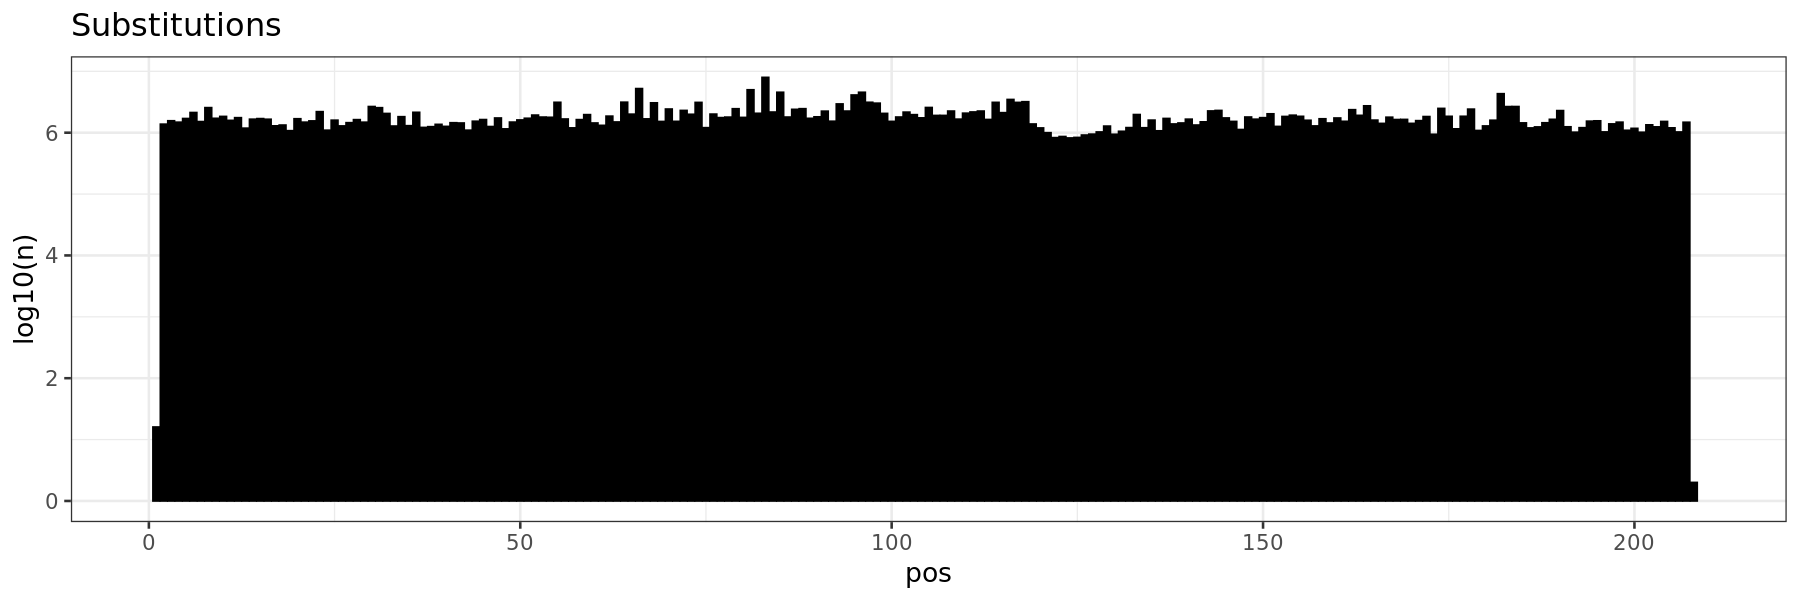

In [110]:
options(repr.plot.width = 15, repr.plot.height = 5, warn = -1)
substitutions %>% 
    filter(pos <= 210) %>%
    group_by(pos) %>%
    summarize(n = sum(count)) %>%
    ggplot() + 
        geom_bar(aes(x = pos, y = log10(n)), stat = "identity", color = "black", fill = "black") +
        theme_bw(base_size = 16) +
        xlim(c(0,210)) + 
        ggtitle("Substitutions")

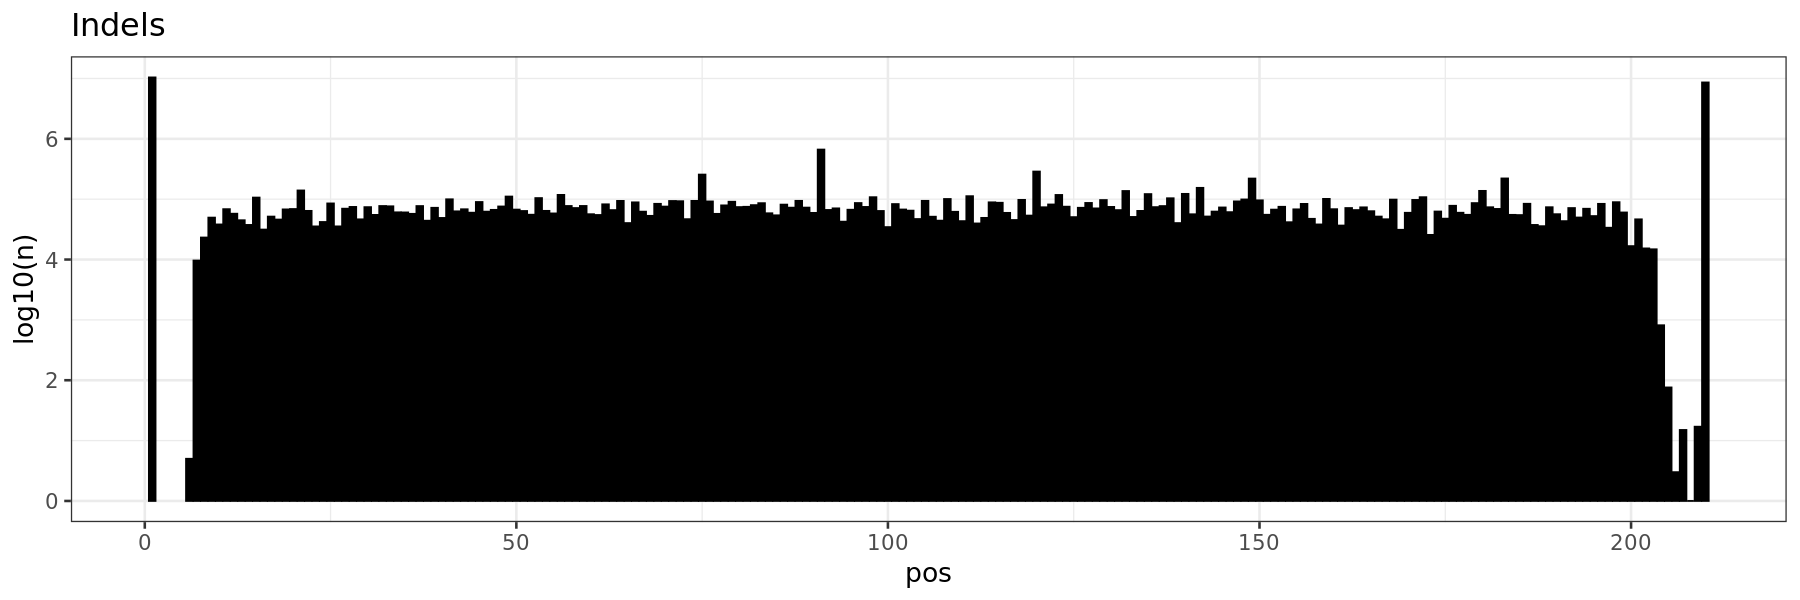

In [111]:
options(repr.plot.width = 15, repr.plot.height = 5)
indels %>% 
    filter(pos <= 210) %>%
    group_by(pos) %>%
    summarize(n = sum(count)) %>%
    ggplot() + 
        geom_bar(aes(x = pos, y = log10(n)), stat = "identity", color = "black", fill = "black") +
        theme_bw(base_size = 16) +
        ggtitle("Indels")

Note that in the indel plot, there is a gap towards the ends followed by a spike. This is induced by the aligner - it does not effectively resolve indels located in the first or last 6 bases of the fragment, and so just chops off the end entirely. In those cases, the reads are represented by the spike at each end, depending on whether it was a 5-prime or 3-prime truncation. In all other cases, the shown indel position is the **right-most** position of the deleted or inserted region, which is why the right-side gap is a bit more filled in than the left-side.

### Error Distributions by Base Identity <a name="part4"></a>

Since there is not much positional specificity, we can instead look at the base composition stratified by position. For indels this is tricky since indels have variable length and involve multiple bases, but for substitutions it is straightforward to count how many reads contain each of the possible single base changes:

In [ ]:
mut_by_samp <- substitutions %>%
    group_by(sample, ref, alt) %>%
    summarize(count = sum(count))

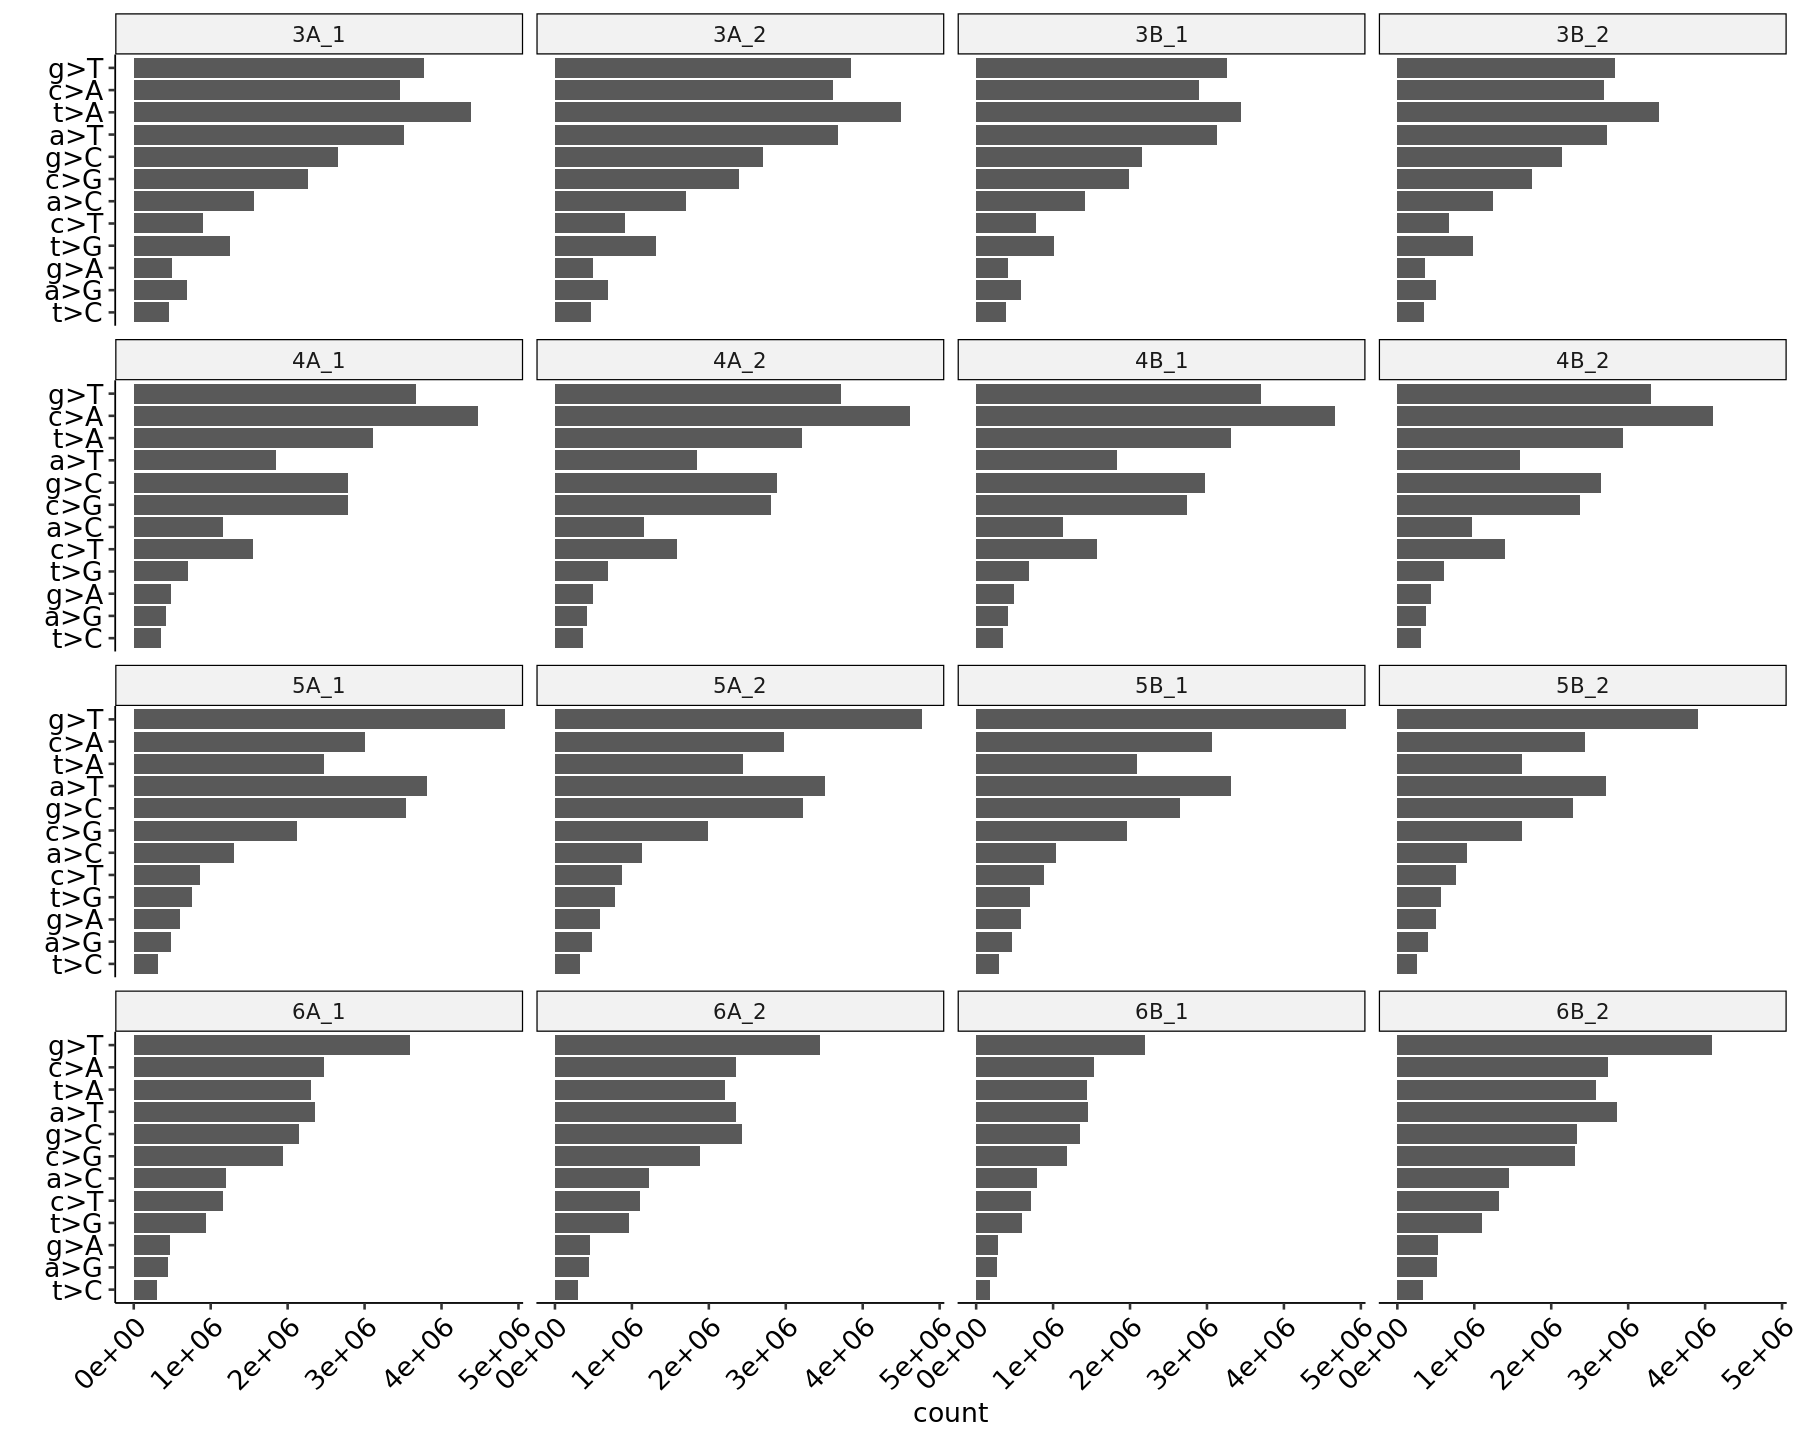

In [175]:
options(repr.plot.width = 15, repr.plot.height = 12)
mut_by_samp %>%
    filter(alt != "N") %>%
    ggplot() +
        geom_bar(aes(x = count, y = reorder(paste0(ref,">",alt),count)), position = position_dodge(),stat = "identity") +
        facet_wrap(~sample) +
        theme_pubr(base_size = 16, x.text.angle = 45) + ylab("")

In [ ]:
basecallfiles <- dir_ls("../pipeline/batch2/", glob = "*basequalcounts*")
names(basecallfiles) <- gsub("../pipeline/batch2/|.dnaerrors-substitutions-basequalcounts.tsv","",
                             basecallfiles,perl=T)
basequals <- basecallfiles %>% map_dfr(read_tsv, .id = "sample", col_names = c("count","base_qual"))

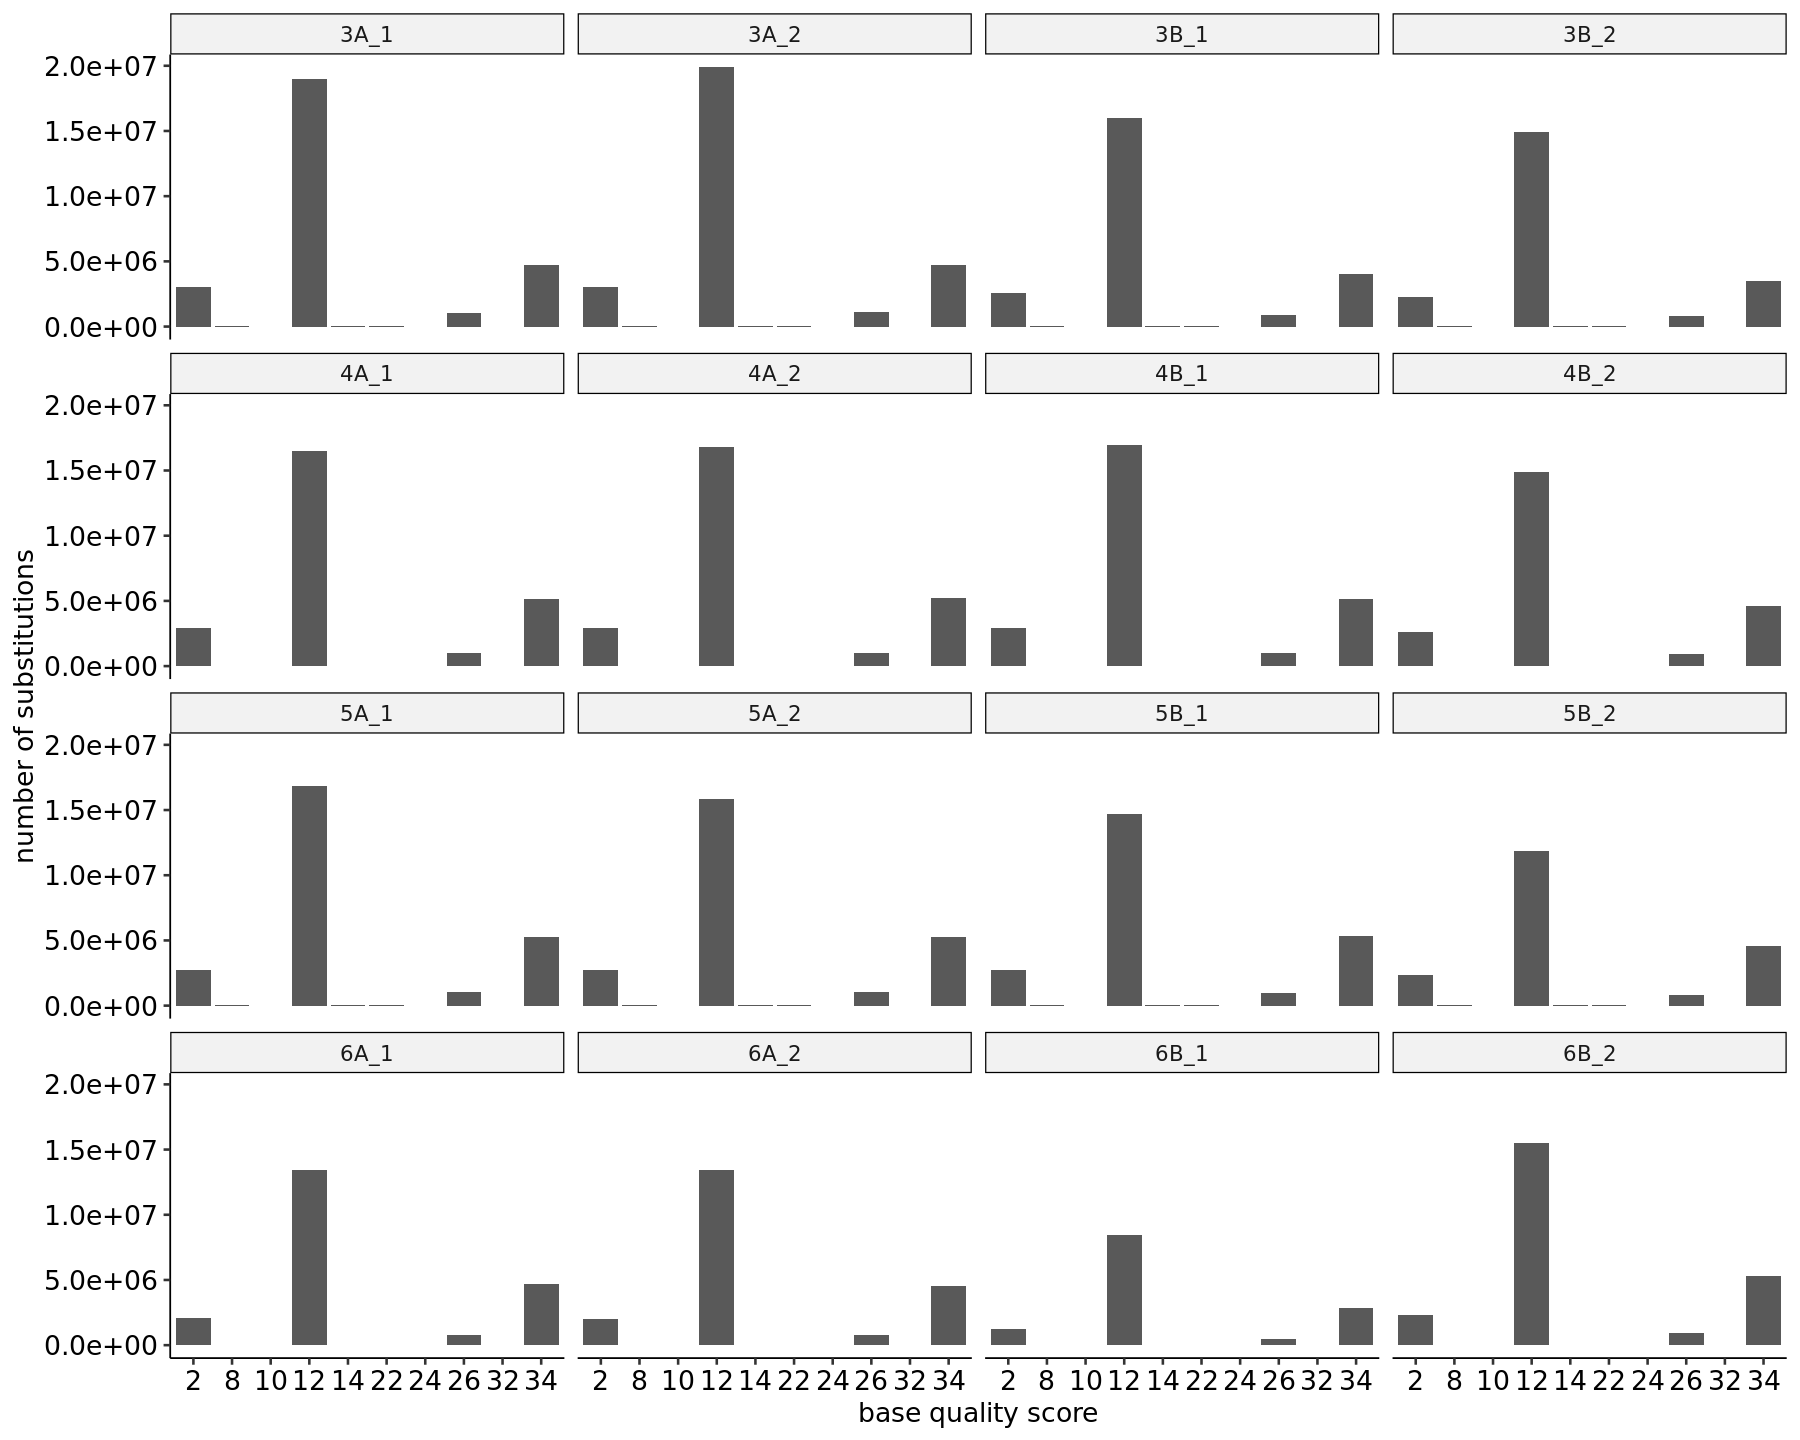

In [164]:
ggplot(basequals) +
    geom_bar(aes(x = as.factor(base_qual), y = count), stat = "identity") +
    facet_wrap(~sample) +
    theme_pubr(base_size = 16) + xlab("base quality score") + ylab("number of substitutions")

We can use the base quality to separate out substitutions that are likely sequencing or basecalling errors from substitutions which is unlikely to be a sequencing error (according to the basecalling algorithm). This changes the error spectrum substantially:

In [ ]:
basecallfiles <- dir_ls("../pipeline/batch2/", glob = "*-substitutions-counts-highlowbasequal.tsv")
names(basecallfiles) <- gsub("../pipeline/batch2/|.dnaerrors-substitutions-counts-highlowbasequal.tsv","",
                             basecallfiles,perl=T)
error_bq <- basecallfiles %>% map_dfr(read_tsv, .id = "sample", col_names = c("count","ref","alt","base_qual"))

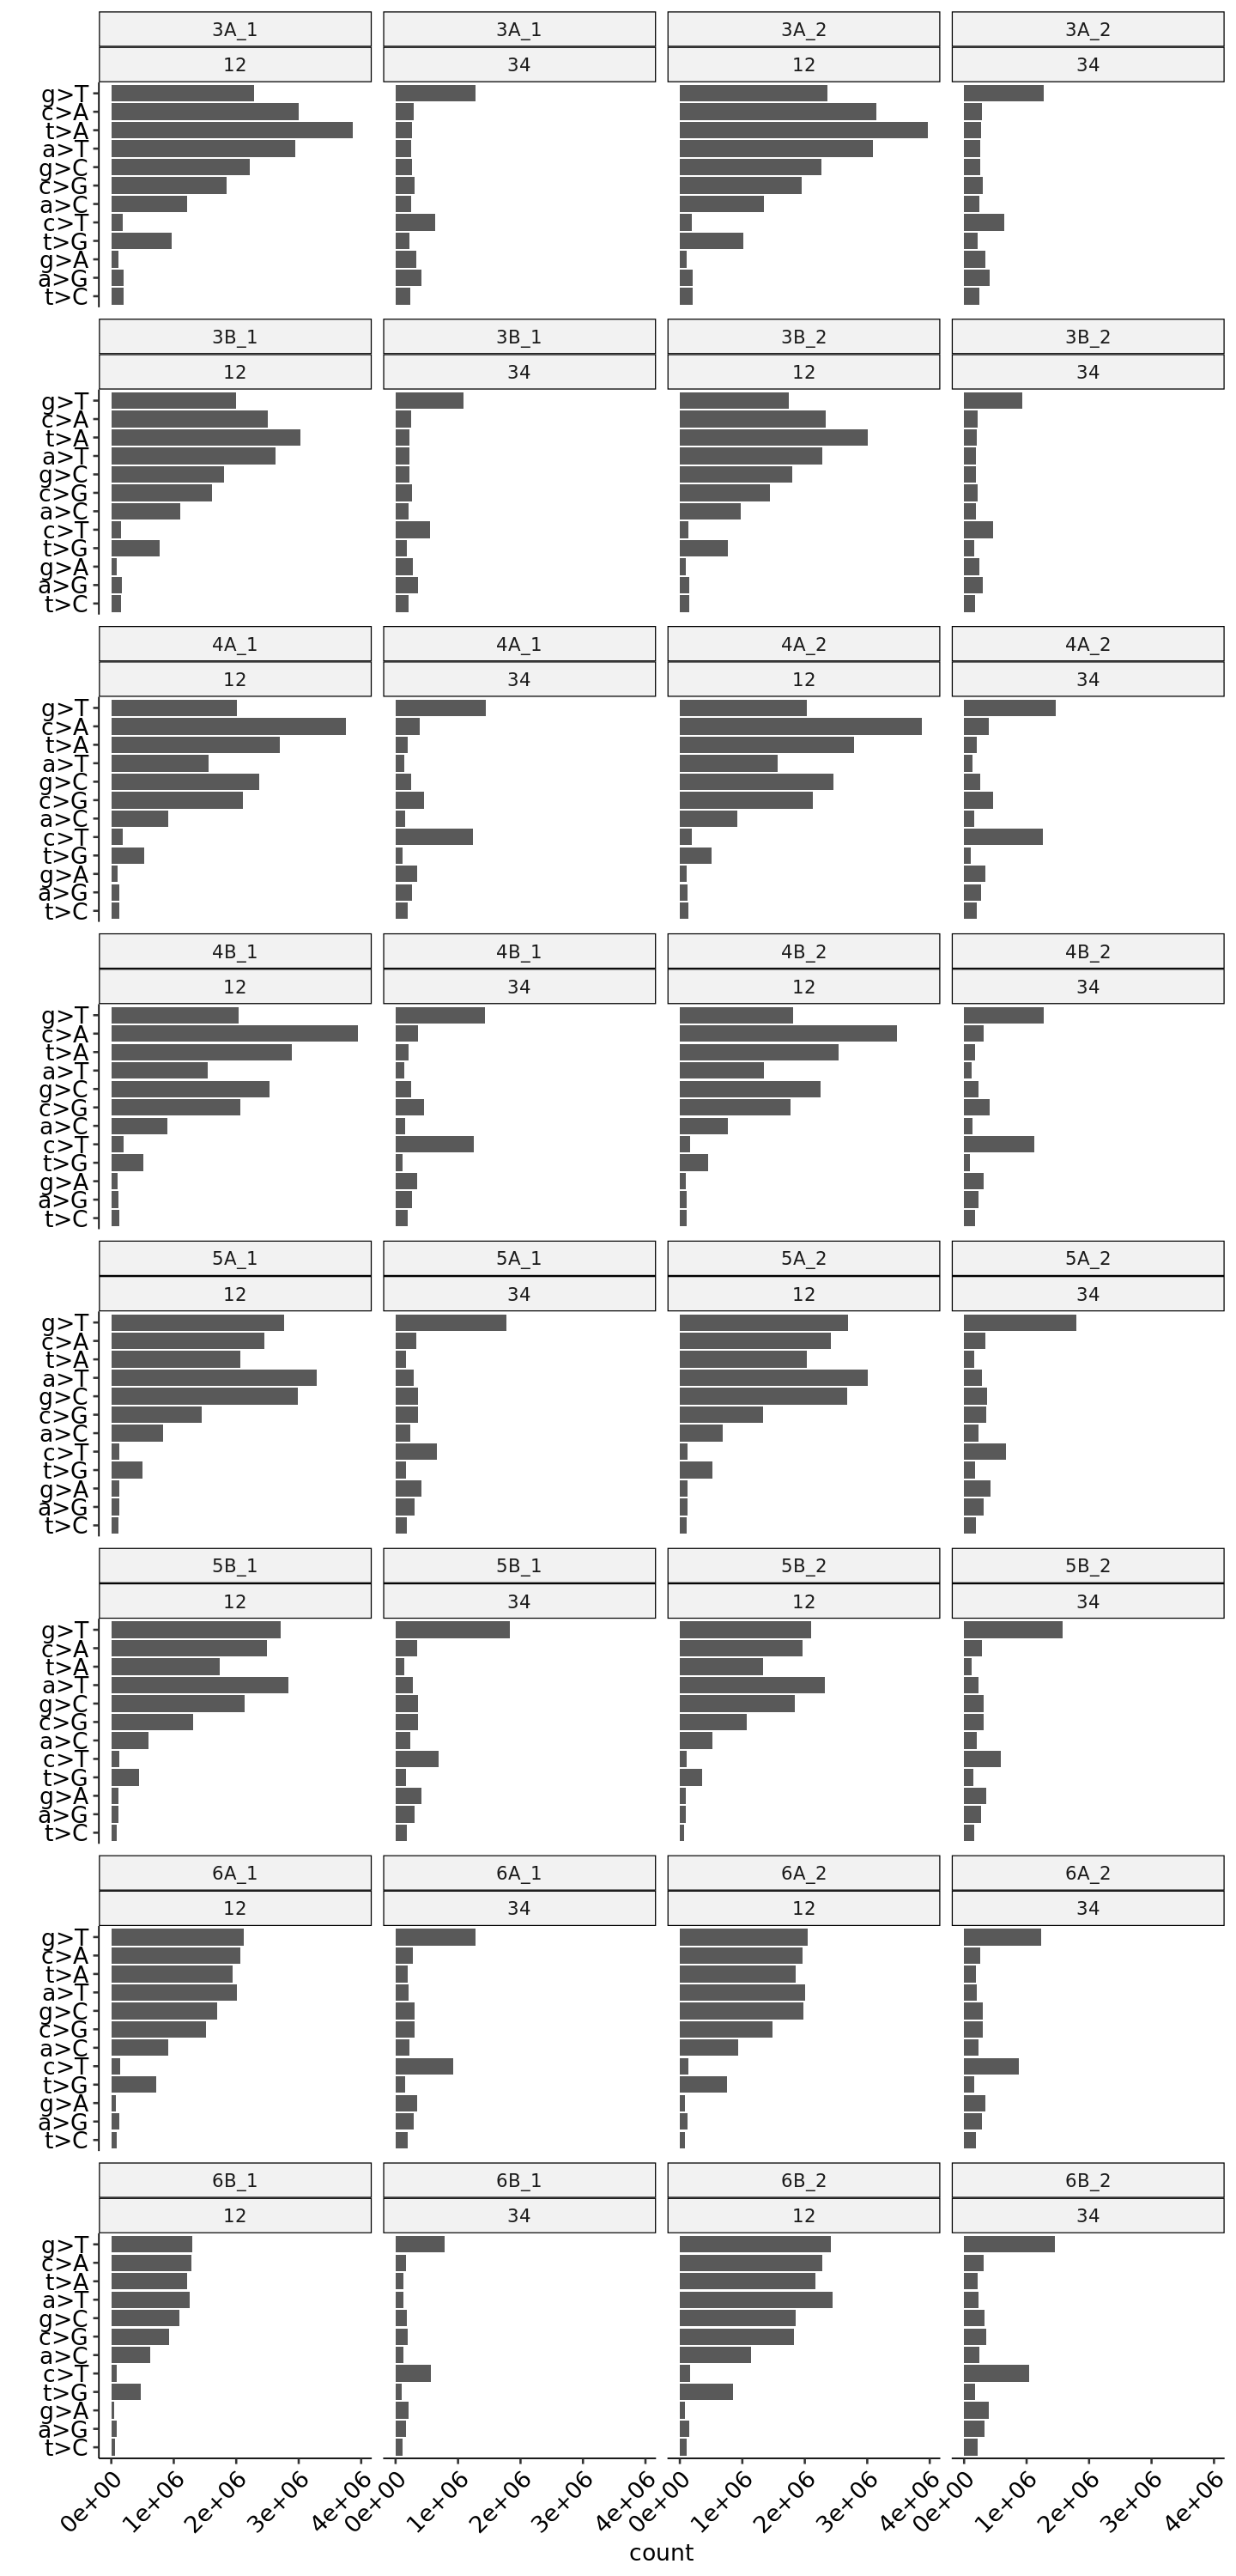

In [177]:
options(repr.plot.width = 12, repr.plot.height = 25)
ggplot(error_bq) +
        geom_bar(aes(x = count, y = reorder(paste0(ref,">",alt),count)), position = position_dodge(),stat = "identity") +
        facet_wrap(~sample+base_qual, ncol = 4) +
        theme_pubr(base_size = 16, x.text.angle = 45) + ylab("")